In [1]:
import numpy as np
import sys
sys.path.append('/home/smatthe2/GillesPy2')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# devils Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in *Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969.*  The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

In [2]:
class Devilsv101(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression="1"))
        self.add_parameter(Parameter(name="K", expression="217"))
        self.add_parameter(Parameter(name="ds", expression="0.22"))
        self.add_parameter(Parameter(name="dI", expression="1.28"))
        self.add_parameter(Parameter(name="L", expression=".75"))
        self.add_parameter(Parameter(name="k0", expression="4"))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=0, mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1, 'Devils': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/K)"))
        self.add_reaction(Reaction(name="death_S", reactants={'S': 1, 'Devils': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1, 'I': 1}, products={'E': 1, 'I':1}, propensity_function="k0*S*I/K"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        self.add_reaction(Reaction(name="death_I", reactants={'I': 1, 'Devils': 1}, products={}, propensity_function="dI*I"))

        # Timespan
#         self.timespan(np.linspace(0, 422, 421)) # month data tspan

In [3]:
model = Devilsv101()

In [4]:
print(np.linspace(0,422,421)[-1])

422.0


## Read in observed data

In [5]:
import pandas as pd

# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('../month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
init_devils_pop = devil_pop[0]
dftd_pop = .1*init_devils_pop

model.listOfParameters['K'].expression = max(devil_pop)*1.16

model.listOfSpecies['Devils'].initial_value = init_devils_pop
model.listOfSpecies['I'].initial_value = dftd_pop  # This will be overwritten by variables later
model.listOfSpecies['S'].initial_value = init_devils_pop - dftd_pop

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
print(obs)
print(model)

[[[34615.70418 34615.70418 34741.36901 34867.03384 35055.53109
   35244.02834 35432.52558 35621.02283 35872.35249 35998.01732
   36186.51457 36375.01181 36563.50906 36752.0063  36877.67114
   37129.0008  37254.66563 37443.16287 37631.66012 37945.8222
   38134.31944 38259.98427 38448.48152 38636.97877 38888.30843
   39076.80567 39265.30292 39453.80017 39705.12983 39956.45949
   40333.45398 40459.11881 40773.28089 40961.77814 41150.27538
   41338.77263 41590.10229 41841.43195 41967.09678 42155.59403
   42281.25886 42721.08577 42909.58301 43035.24784 43286.57751
   43412.24234 43663.572   43789.23683 43977.73407 44040.56649
   44166.23132 44229.06374 44354.72857 44417.56098 44480.3934
   44543.22581 44668.89064 44668.89064 44794.55547 44794.55547
   44920.22031 44983.05272 45108.71755 45422.87963 45611.37688
   45737.04171 45862.70654 46051.20378 46239.70103 46365.36586
   46428.19828 46616.69552 46805.19277 46930.8576  47370.68451
   47559.18175 47810.51141 47936.17624 48187.50591 48376.

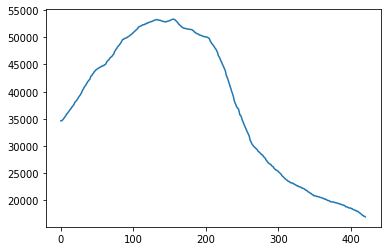

In [6]:
plt.plot(range(0,len(devil_pop)), devil_pop)

## Configure Solver Widget

In [7]:
# solver = ODECSolver(model, variable=True)
solver = SSACSolver(model, variable=True)

In [40]:
def f(L, k0, r, sTime, eTime, dI, ds):
    title = 'Total Species for Time Range {0}-{1}'.format(sTime, eTime)
    print('=================================')
    print('| Time Range: {}-{}'.format(sTime, eTime))
    print('| -------------------------------')
    print('| Input Parameters:')
    print('| \tL: {}, k0: {}'.format(L, k0))
    print('| \tr: {}'.format(r))
    print('| \tds: {}'.format(ds))
    print('| -------------------------------')
#     print('| Initial Value of I: {}'.format(dfdt_pop[sTime]))
#     print('| -------------------------------')
#     print('| Ratio of dI:r:')
#     print('| \t{}:{}'.format(str(dI), str(r)))
    print('=================================')
    
    print(sTime)
    
    print(devil_pop[sTime])
    model.listOfSpecies['I'].initial_value = round(devil_pop[sTime]*.001)  # This will be overwritten by variables later
    model.listOfSpecies['S'].initial_value = round(devil_pop[sTime]*.999)
    
#     # MAP TO NO INFECTION
#     model.listOfSpecies['I'].initial_value = 0  # This will be overwritten by variables later
#     model.listOfSpecies['S'].initial_value = round(devil_pop[sTime])
    
    model.listOfSpecies['Devils'].initial_value = round(devil_pop[sTime])
    
    results = solver.run(model=model, variables={'L':str(L), 'r':str(r), 'k0':str(k0), 'dI': str(dI), 'ds': str(ds)}, t=eTime-sTime, increment=1)
#     print(results)
#     if len(res) > 0:
#         print('>0')
#         results_list = []
#         for i in range(0, len(res)):
#             temp = gillespy2.Trajectory(data=res[i], model=model, solver_name=solver.name)
#             results_list.append(temp)

#         results = gillespy2.Results(results_list)

#     print('RESULTS')
#     print(results)
    total_devils = np.add(np.add(results['I'], results['S']), results['E'])
    print(model.listOfParameters['K'])
#     print('I: ', results['I'], '\nS: ', results['S'], '\nE: ', results['E'], '\ntotal: ', total_devils)

    simulated_devils = plt.plot(range(sTime, eTime+1), total_devils, 'b', label='Simulated Total')
    s_devils = plt.plot(range(sTime, eTime+1), results['S'], 'g', alpha=.3, label='Susceptible')
    i_devils = plt.plot(range(sTime, eTime+1), results['I'], 'r', alpha=.3,label='Infected')
    e_devils = plt.plot(range(sTime, eTime+1), results['E'], 'y', alpha=.3,label='Exposed')
    expected_devils = plt.plot(range(sTime, eTime), devil_pop[sTime:eTime], '--b', label='Observed Total')
#     print('Exposed')
#     print(results['E'])
    plt.xlabel('month')
    plt.ylabel('population')
    plt.legend(loc='best')
    plt.title(title)
    result_str = 'TOTAL Expected: {0} - Got: {1}'.format(devil_pop[eTime-1], total_devils[-1])

    return result_str

In [43]:
# Create Widgets
month = 12
dL = widgets.FloatSlider(min=0, max=10/month, step=0.01, value=0.75/month)
dk0 = widgets.FloatSlider(min=0, max=10/month, step=0.01, value=4/month)
dds = widgets.FloatSlider(min=0, max=.05, step=.0001, value=.0038)
ddI = widgets.FloatSlider(min=0, max=.1, step=.001, value=.02)
# dInfection = widgets.FloatSlider(min=0, max=.1, step=.001, value=0.024)
dr = widgets.FloatSlider(min=0, max=1/month, step=0.001, value=.029)
dsTime = widgets.IntSlider(min=0, max=420, step=1, value=132)
deTime = widgets.IntSlider(min=1, max=421, step=1, value=421)

## Run the widget and attempt to calibrate model

In [44]:
# Run interactions
interact(f, L=dL, k0=dk0, r=dr, sTime=dsTime, eTime=deTime, dI=ddI, ds=dds)

interactive(children=(FloatSlider(value=0.0625, description='L', max=0.8333333333333334, step=0.01), FloatSlid…

<function __main__.f(L, k0, r, sTime, eTime, dI, ds)>